In [2]:
#Installing all dependencies

import strawberryfields as sf
from strawberryfields.ops import *
# from strawberryfields.utils import scale
from numpy import pi, sqrt
import math
import random
from scipy.optimize import minimize

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from scipy.integrate import simps

sf.hbar = 0.5
eng = sf.Engine("fock", backend_options={"cutoff_dim":10})
prog = sf.Program(2)

with prog.context as q:
    
    Fock(2) | q[0]

state = eng.run(prog, run_options={"eval": False}).state
wigner = a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

In [4]:
x = [i/10 for i in range(-40, 40)]

def wigner_transform(x, wigner):

    y = []

    for i in range(0, len(x)):
        res = simps([wigner[k][i] for k in range(0, len(x))], x)
        y.append(res)

    return y

data = wigner_transform(x, wigner)

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\1834671164.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


Finally, we have to plot our data as a quadrature graph:

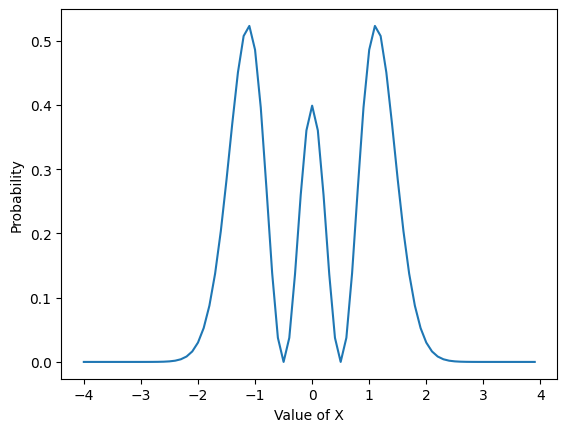

In [5]:
plt.plot(x, data)
plt.xlabel("Value of X")
plt.ylabel("Probability")

plt.show()

It works!

In [6]:
#Defines the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defines the value of the parabolic minimum

parabolic_min = 0.83

We will now define our classical cost function, which is fairly easy in Python:

In [7]:
#Defines the classical cost function

def function_optimize(x, parabolic_min):
    y = (x - parabolic_min)**2
    return y

We now have to define our cost unitary, to be used in the QAOA process, which again, we can do fairly easily:

In [8]:
#Defines the cost unitary for QAOA

def cost_ham(q, p):

    Zgate(parabolic_min*2*hbar*p) | q[0]
    Pgate(-2*hbar*p) | q[0]

In [9]:
#Defines the kinetic mixer unitary for QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Pgate(-1*hbar*p) | q[0]
    Rgate(math.pi/2) | q[0]

    return q 

We have a few more parameters that we have to define as well before we run our simulation. We have to choose our circuit depth, which is the number of times the cost-mixer unitary is applied and the photon cutoff dimension for our Strawberry Fields simulation. In addition, we have to choose our **squeezing parameter**. We will be initializing our simulation in a squeezed state over the $x$-quadrature, in order to ensure that our algorithm searches over a large space of possible solutions:

In [10]:
#Defines the circuit depth, cutoff dimension, and the squeezing parameter

circuit_depth = 3
squeezing = -0.5
cutoff = 5

Now, we are in a position to define our first circuit, which will return numerical values for our graphical visualization. Note that this is not the function that we will be using for the actual optimization of the circuit, as this function does not sample the circuit, but rather returns Wigner function values for our graph.  We will find Wigner function values ranging from $-30$ to $30$, for both the $x$ and $p$ quadratures, with a spacing of $0.1$ between measured values. In addition, we will only optimize over one parameter, as the function we are optimizing is a fairly simple one:

In [11]:
#Defines the function used to run the circuit and return numerical data

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state
    a = state.wigner(0, [i/10 for i in range(-30, 30)], [i/10 for i in range(-30, 30)])
    return a

Next, we will define our "sampling function", which is identical to the one that we just provided, except instead of returning numerical Wigner function values, we will actually sample the circuit for individual values:

In [12]:
#Defines the sampling circuit simulation

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0,circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

        MeasureX | q[0]

    result = eng.run(prog)
    return result.samples[0]

We now have to specify how many times we will sample the circuit, to obtain a decently accurate value for the expectation value of our cost Hamiltonian. For now, we will choose $15$ as the number of our samples.

In [13]:
#Defines the number of iterations that the circuit is sampled

shots = 15

We now have to define our **objective function**, which is the function that we will attempt to optimize with our classical optimizer. As the cost, we will return the average of our repeated samples of the circuit:

In [14]:
#Defines the objective function that is minimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av
        calculation = function_optimize(result1, parabolic_min)
        costly = costly + calculation

    costly = costly/shots


    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Next, we will define the actual classical optimizer that we will use to minimize the objective function. For this implementation, we will use the Nelder-Mead optimizer. For our initial parameter, we will choose a random value from $-3$  to $3$ (this was arbitrary, there is probably a better way to choose this initial parameter based on traditional gradient descent methods, but for now, a random value in this aarbitrary range will suffice). Finally, we will run our numerical circuit one more time with the optimal parameters, in order to get Wigner function values for our graphical visualization:

Paramter: [-1.18]
Value of Cost Function: [0.4626381]
Paramter: [-1.239]
Value of Cost Function: [0.26780675]
Paramter: [-1.298]
Value of Cost Function: [0.26684236]
Paramter: [-1.357]
Value of Cost Function: [0.25123472]
Paramter: [-1.475]
Value of Cost Function: [0.11382929]
Paramter: [-1.593]
Value of Cost Function: [0.16862078]
Paramter: [-1.593]
Value of Cost Function: [0.2364585]
Paramter: [-1.534]
Value of Cost Function: [0.41430367]
Paramter: [-1.416]
Value of Cost Function: [0.41204139]
Paramter: [-1.534]
Value of Cost Function: [0.27979547]
Paramter: [-1.5045]
Value of Cost Function: [0.43050168]
Paramter: [-1.4455]
Value of Cost Function: [0.20232079]
Paramter: [-1.5045]
Value of Cost Function: [0.34990203]
Paramter: [-1.46025]
Value of Cost Function: [0.26320137]
Paramter: [-1.46025]
Value of Cost Function: [0.2206666]
Paramter: [-1.48975]
Value of Cost Function: [0.11816108]
Paramter: [-1.482375]
Value of Cost Function: [0.17017693]
Paramter: [-1.467625]
Value of Cost Func

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\1780041136.py:15: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


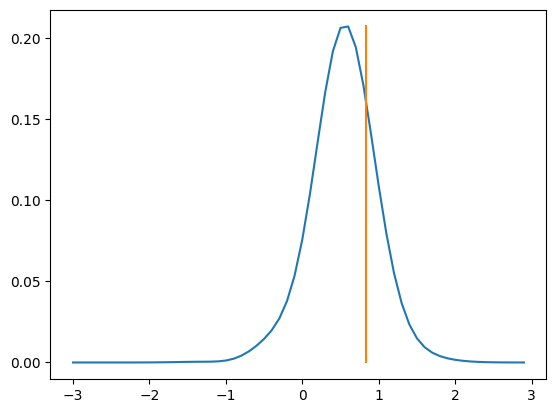

In [15]:
#Defines the optimizer that minimizes the objective function

out = minimize(objective, x0=[random.randint(-150,150)/100], method="Nelder-Mead", options={'maxiter':20})
print(out)

#Creates the graphical visualization

final = run_circuit(out['x'])

x = [i/10 for i in range(-30, 30)]
y = []


for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.plot(x, y)
plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

plt.show()

In [16]:
#Defining the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defining the classical cost function

def function_optimize(x1, x2):
    y = x1**2 + x2**2 + x1 + x2 + x1*x2
    return y

In [17]:
#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(-1**hbar*p) | q[1]
    Pgate(-2*hbar*p) | q[1]
    Zgate(-1*hbar*p) | q[0]
    Pgate(-2*hbar*p) | q[0]
    CZgate(-3*hbar*p) | (q[0], q[1])

    return q

In [18]:
#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

In [19]:
#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 8
circuit_depth = 3

In [23]:
#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    # return [result.samples[0], result.samples[1]]
    return result.samples[0].tolist()


We will choose our number of iterations, and specify the objective function:

In [24]:
#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Paramter: [ 0.03 -0.01]
Value of Cost Function: 0.45213048839788883
Paramter: [ 1.03 -0.01]
Value of Cost Function: 0.33386218771036835
Paramter: [1.03 0.99]
Value of Cost Function: 1.0757102409972497
Paramter: [ 1.18743575 -0.99752923]
Value of Cost Function: 1.1423469275909843
Paramter: [ 1.10871787 -0.50376462]
Value of Cost Function: 0.03339815859316534
Paramter: [ 1.20704446 -0.99400117]
Value of Cost Function: 1.335674285452142
Paramter: [ 1.35560018 -0.46440568]
Value of Cost Function: 0.8120737812277508
Paramter: [ 0.63880637 -0.67459547]
Value of Cost Function: 1.5285123097933455
Paramter: [ 1.35860722 -0.51120192]
Value of Cost Function: 0.14056311028148263
Paramter: [ 1.03983941 -0.60807548]
Value of Cost Function: 0.7660557950059615
Paramter: [ 1.10495938 -0.37882113]
Value of Cost Function: 1.0284411366865567
Paramter: [ 1.16794918 -0.5237121 ]
Value of Cost Function: 0.8496566336810413
Paramter: [ 1.09066053 -0.47825981]
Value of Cost Function: 0.38218350759860026
Paramte

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\2680331573.py:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\2680331573.py:25: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


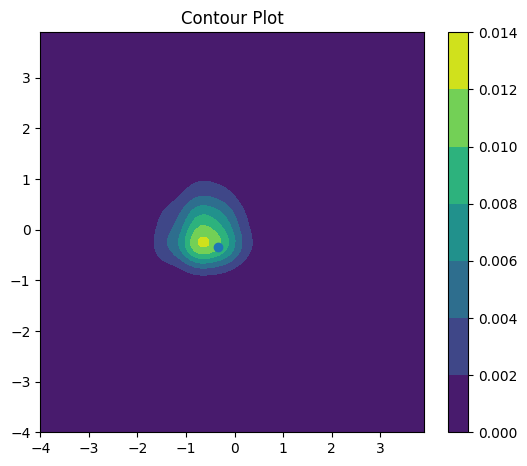

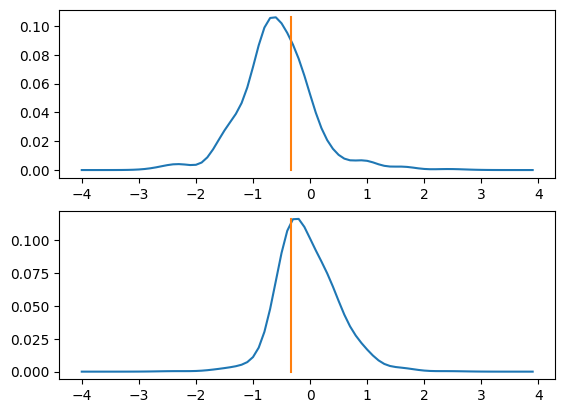

In [25]:
out = minimize(objective, x0=[random.randint(-100,100)/100, random.randint(-100,100)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(-1)/3], [float(-1)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

The blue dot on the contour graph corresponds to the optimal point. I really feel like I'm cheating with respect to this implementation, as I went through many different values of the parameters, like squeezing, cutoff dimension, and circuit depth to find this solution (which is really good)! For the most part, this example, when I ran it locally, was super volatile, and didn't work a lot of the time. I think it would be interesting to see an extension of this algorithm, where not only the unitaries are parametrized, but so are other parameters (like the squeezing parameter, cutoff dimension, and circuit depth). I would also hope that the algorithm performs better and more consistently when we are able to choose our initial parameters with an actual strategy rather than blinding picking some arbitrary set of numbers. Let's try another example, but this time, let's be a bit harder on ourselves and actually sample the function to obtain an optimal value (as one is supposed to do with an optimization algorithm)! Consider the function given as:

<br><br>
$$f(x, \ y) \ = \ 2x^2 \ + \ 2xy \ - \ 6x \ + \ 2y^2 \ - \ 5y \ + \ 10$$
<br>
$$\text{min} \ f(x, \ y) \ = \ \frac{29}{6} \ \Rightarrow \ (x, \ y) \ = \ \Big( \frac{7}{6}, \ \frac{2}{3} \Big)$$
<br><br>

Let's try optimizing this! For this function, since the distance between the optimal values of $x$ and $y$ is larger, we will st Planck's constant to $1$ to acheive larger variance without applying ridiculous amounts of squeezing (which can also mess up the simulation). By this point, you pretty much get the idea of how we implement the algorithm, so I won't go through all of it. Note that I am only re-defining the things that change, the rest will stay the same from the previous example:

Paramter: [0.22 0.42]
Value of Cost Function: 21.44940514475795
Paramter: [1.22 0.42]
Value of Cost Function: 24.225151977950368
Paramter: [0.22 1.42]
Value of Cost Function: 34.338880653112504
Paramter: [ 0.00947639 -0.55758877]
Value of Cost Function: 23.54485606796687
Paramter: [ 0.11473819 -0.06879439]
Value of Cost Function: 9.12718111084283
Paramter: [ 0.05870257 -0.56564447]
Value of Cost Function: 32.813836711986184
Paramter: [-0.13368685 -0.04077657]
Value of Cost Function: 13.937002724394118
Paramter: [0.35360758 0.37045659]
Value of Cost Function: 12.811921045806388
Paramter: [0.23417289 0.1508311 ]
Value of Cost Function: 12.584910661488069
Paramter: [ 0.18426878 -0.17267171]
Value of Cost Function: 10.34514074404703
Paramter: [ 0.05294348 -0.07815728]
Value of Cost Function: 11.713067556313149
Paramter: [ 0.15911743 -0.02478605]
Value of Cost Function: 9.753432920349727
Paramter: [ 0.13395457 -0.09343771]
Value of Cost Function: 7.417216546122531
Paramter: [ 0.15153346 -0.

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\4188642262.py:162: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\4188642262.py:173: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


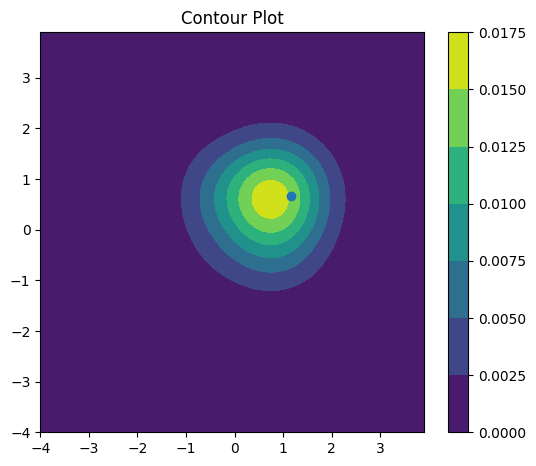

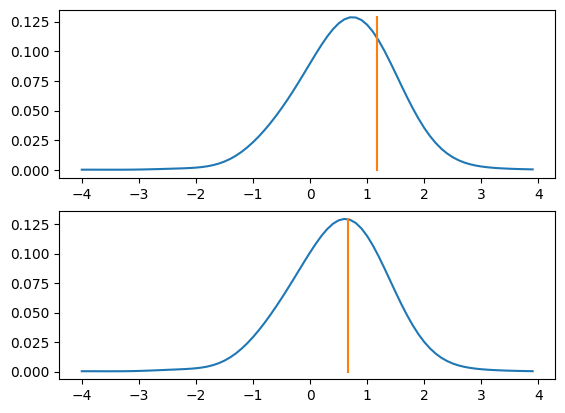

In [27]:
#Defining the value of h-bar

sf.hbar = 2
hbar = 2

#Defining the classical cost function

def function_optimize(x1, x2):
    y = 2*(x1**2) + 2*x1*x2 - 6*x1 + 2*(x2**2) - 5*x2 + 10
    return y

#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(5*hbar*p) | q[1]
    Pgate(-4*hbar*p) | q[1]
    Zgate(6*hbar*p) | q[0]
    Pgate(-4*hbar*p) | q[0]
    CZgate(-6*hbar*p) | (q[0], q[1])

    return q

#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 6
circuit_depth = 4

#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    # return [result.samples[0], result.samples[1]]
    return result.samples[0].tolist()

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

#Define the optimizer that is used to find the optimal value of the objective function

out = minimize(objective, x0=[random.randint(-50,50)/100, random.randint(-50,50)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Defines the sampling method that finds the exact optimal value
samples = 200

optimal_cost = math.inf
optimal_val = 0

for t in range(0, samples):
    final_function = old_circuit(out['x'])
    if (function_optimize(final_function[0], final_function[1]) < optimal_cost):
        optimal_val = final_function
        print(optimal_val)
        optimal_cost = function_optimize(final_function[0], final_function[1])

print("The Optimal Value Is: "+str(optimal_val))


#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(7)/6], [float(2)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(7)/6 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(2)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

In [28]:
#Implementing the sub-component gate involved in quartic decomposition

def crazy_gate(omega, q, selector):

    Vgate(0.25*3*hbar*omega) | q[selector+1]
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-2*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-1*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(2*hbar) | (q[selector], q[selector+1])
    
    return q

We can then construct a function that returns the quartic gate:

In [29]:
#Defining the quartic gate, in terms of a decomposition

def quartic_gate(q, alpha, selector):

    Rgate(math.pi/2) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Rgate(math.pi/2) | q[selector+1]
    Pgate(-2*hbar*alpha) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Pgate(2*hbar*alpha) | q[selector+1]
    crazy_gate(2*alpha, q, selector)

And that concludes our small detour! Now, let us turn our attention to the function that we wish to optimize, which is:

<br><br>
$$f(x, \ y) \ = \ 0.5x^4 \ - \ 8x^2$$
<br>
$$\text{min} \ f(x, \ y) \ = \ -32 \ \Rightarrow \ x \ = \ \pm \ 2 \sqrt{2}$$
<br><br>

Excellent, so we can now implement our simulation one more time. As usual, we first have to define our value of Planck's constant, ass well as our classical cost function, which will be given as:

In [30]:
#Defining the value of h-bar

sf.hbar = 1
hbar = 1

#Defining the classical cost function that we are trying to optimize

def function_optimize(x1):
    y = 0.5*(x1**4) - 8*(x1**2)
    return y

Next, we define our cost and mixer unitaries:

In [31]:
#Defining the cost unitary to be used in QAOA

def cost_ham(q, p):

    quartic_gate(q, -0.5, 0)
    Pgate(16*hbar*p) | q[0]

#Defining the kinetic mixer unitary to be used in QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Pgate(-1*hbar*p) | q[0]
    Rgate(math.pi/2) | q[0]

    return q

We then define our parameters, and our numerical circuit simulator:

In [32]:
#Defining the depth of the QAOA circuit to be constructed, the squeezing parameter, and the cutoff dimension

circuit_depth = 10
squeezing = -0.5
cutoff = 7


# Defining the function that simulates the circuit, and returns the results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state
    a = state.wigner(0, [i/100 for i in range(-500, 500)], [i/100 for i in range(-500,500)])

    return a

Now here is where things get interesting.........

In [33]:
#Defining the objective function that will be minimized by the optimizer

def new_objective(param):

    av = run_circuit(param)

    y = []
    x = [i/100 for i in range(-500, 500)]
    for i in range(0, len(x)):
        res = simps([av[k][i] for k in range(0, len(x))], x)
        y.append(res)

    norm_factor = simps(y, x)
    y = [y[i]/norm_factor for i in range(0, len(y))]

    first_x_2 = [(x[i]**2)*y[i] for i in range(0, len(x))]
    first_x_4 = [(x[i]**4)*y[i] for i in range(0, len(x))]

    i2 = simps(first_x_2, x)
    i3 = simps(first_x_4, x)

    calculation = 0.5*i3 - 8*i2

    print("Value of Cost Function: "+str(calculation))

    return calculation

As you can see, we run the numerical circuit simulator once, and integrate to get expectation values for $x^4$ and $x^2$. You should also notice that we normalize our data points before integrating. This is just due to quartic gates leading to highly unnormalized final states, with ridiculously small values as data points. This leads to Python occasionally getting confused, and thinking it is dividing by $0$ (yes, the probabilities get that small). To get around this issue, we simply normalize the data before we calculate the expectation values.

Finally, we define our optimizer and our visualization:

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


Value of Cost Function: -16.070976622275197
Value of Cost Function: -16.11969004157163
Value of Cost Function: -15.05350916027996
Value of Cost Function: -17.608221212018748
Value of Cost Function: -18.446435594551588
Value of Cost Function: -18.804278719562873
Value of Cost Function: -19.001550343932276
Value of Cost Function: -19.107094664005988
Value of Cost Function: -19.132772928716808
Value of Cost Function: -19.14517195451392
Value of Cost Function: -19.12339882427577
Value of Cost Function: -19.151856640711067
Value of Cost Function: -19.156860870731915
Value of Cost Function: -19.160908077291257
Value of Cost Function: -19.165225752905297
Value of Cost Function: -19.16829782932872
Value of Cost Function: -19.171002290629087
Value of Cost Function: -19.17334447461524
Value of Cost Function: -19.170753301491917
Value of Cost Function: -19.175288791630866
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -19.175288791630866


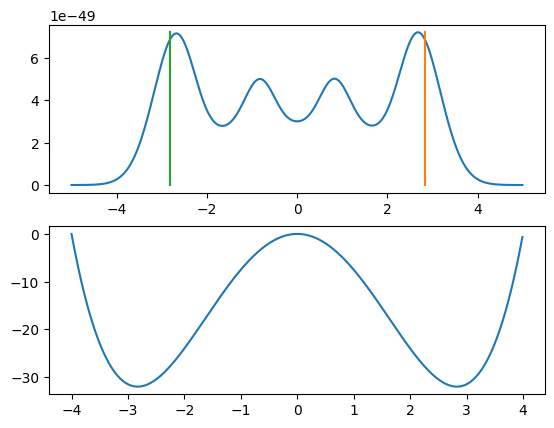

In [34]:
#Define the optimizer that is used to find the optimal value of the cost function

out = minimize(new_objective, x0=[random.randint(-500,500)/100, random.randint(-500,500)/100], method="COBYLA", options={'maxiter':20})
print(out)

#Runs the circuit a final time, with the optimal parameters

final = run_circuit(out['x'])

#Define the arrays used for the graphical visualization

x = [i/100 for i in range(-500, 500)]
x2 = [i/100 for i in range(-400, 400)]
y = []

#Construct the quadrature graph

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.subplot(2, 1, 1)
plt.plot(x, y)

#Plot vertical lines corresponding to the actual optimal solutions

plt.plot([2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])
plt.plot([-2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Plot the actual cost function itself

plt.subplot(2, 1, 2)
plt.plot(x2, [function_optimize(x2[i]) for i in range(0, len(x2))])

plt.show()

So we get pretty great results, with two "spikes" appearing at the minima of the cost function. This simulation, however, required a very deep circuit (depth of $8$), so there is definitely a trade-off that must be considered, between accuracy of the algorithms, and dpeth of the circuit (which on a real quantum computer, would lead to loss of coherence).

**Conclusion** <div id="10"></div>

In conclusion, this notebook was meant to act as expository material, to give the reader an idea of what QAOA and CV QAOA are all about through some interesting physical theory in the first section, and concrete simulations in the second part. I really hope you, the reader, has gained more clarity about the power of an algorithm like QAOA (specifically CV QAOA)!

To address to topic of the accuracy of these simulations, I feel like for a lot of these results, I kind of got lucky. When I ran tests locally, I got a lot of great results, but at the same time, I got a lot of not-so-great results. I also feel as though I am "selecting" ideal parameters for each of the simulations, as a lot of the squeezing parameters, cutoff dimensions, etc. that I tested (which I didn't include in this notebook), did not work very well. Nevertheless, I think this is an interesting starting point to dive further into CV QAOA and conceptualize better training techniques, and more general ways to choose parameters such that convergence of the algorithm can be ensured to a higher degree.

**Acknowledgements** <div id="11"></div>

This notebook would not have been compelted without all the help of Guillaume Verdon, Josh Izaac, Nicolas Quesada, Juan Miguel Arrazola, and Nathan Killoran. Thank you to all of you guys, I really appreciate that you took the time to answer my never-ending stream of questions!

**References**

Original CV QAOA Paper: [https://arxiv.org/abs/1902.00409](https://arxiv.org/abs/1902.00409)
<br>
CV Gate Decomposition Paper: [https://arxiv.org/abs/1811.10651](https://arxiv.org/abs/1811.10651)
<br>
The Code for the Contour Graph was Based Off of a StackExchange Answer (Will Update With Link)
<br>
Gaussian Quantum Information: [https://arxiv.org/abs/1110.3234](https://arxiv.org/abs/1110.3234)
<br>
Original QAOA Paper: [https://arxiv.org/abs/1411.4028](https://arxiv.org/abs/1411.4028)
<br>
Basic Explanation of QAE For QC: [https://quantumcomputing.stackexchange.com/a/5572/4907](https://quantumcomputing.stackexchange.com/a/5572/4907)